In [34]:
import json
import os
import pandas as pd
from typing import *

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from imantics import Polygons

matplotlib.rcParams['figure.dpi'] = 300  # nicer images

In [35]:
def create_stats(img_dirs: List[str], annotation_paths: List[str], dataset_names: List[str]):
    hold_types_per_image = defaultdict(lambda: defaultdict(int))
    total_region_percentages = []
    
    for img_dir, annotation_path, dataset_name in zip(img_dirs, annotation_paths, dataset_names):
        with open(annotation_path, "r") as f:
            img_annotations = json.load(f)["_via_img_metadata"]

        for image in sorted(img_annotations.values(), key = lambda x: x["filename"]):
            # skip images that have no region annotation, i.e. not annotated images
            if not image["regions"]:
                continue

            # skip images which have regions that are not handlabeled
            if not all(
                [
                    region["region_attributes"]["label_type"] == "handlabeled"
                    for region in image["regions"]
                ]
            ):
                continue

            image_filename = os.path.join(img_dir, image["filename"])
            height, width = cv2.imread(image_filename).shape[:2]
            area = height * width
            for region in image["regions"]:
                hold_type = region["region_attributes"]["hold_type"]
                hold_types_per_image[dataset_name + "/" + image["filename"]][hold_type] += 1

                anno = region["shape_attributes"]
                px = anno["all_points_x"]
                py = anno["all_points_y"]
                polygons = [(x, y) for (x, y) in zip(px, py)]

                mask = Polygons(polygons=polygons).mask(height=height, width=width)
                percentage = (mask.sum() / area) * 100
                total_region_percentages.append(percentage)

    return hold_types_per_image, total_region_percentages

In [36]:
holds, region_percentage = create_stats(
    img_dirs=[
        "/aux/Climber Tools/boulderhaus/main/images/converted-downsized",
        "/aux/Climber Tools/boulderhaus/rebuilds/2023-02-04-phone",
        "/aux/Climber Tools/smichoff/boulder/whole/images/converted-downsized",
    ],
    annotation_paths=[
        "data/bh/annotation.json",
        "data/bh-phone/annotation.json",
        "data/sm/annotation.json",
    ],
    dataset_names=[
        "bh",
        "bh-phone",
        "sm",
    ],
    
)

df = pd.DataFrame.from_dict(holds)
df = df.transpose()

In [37]:
df.sum(axis=0)

hold      1597.0
volume      91.0
dtype: float64

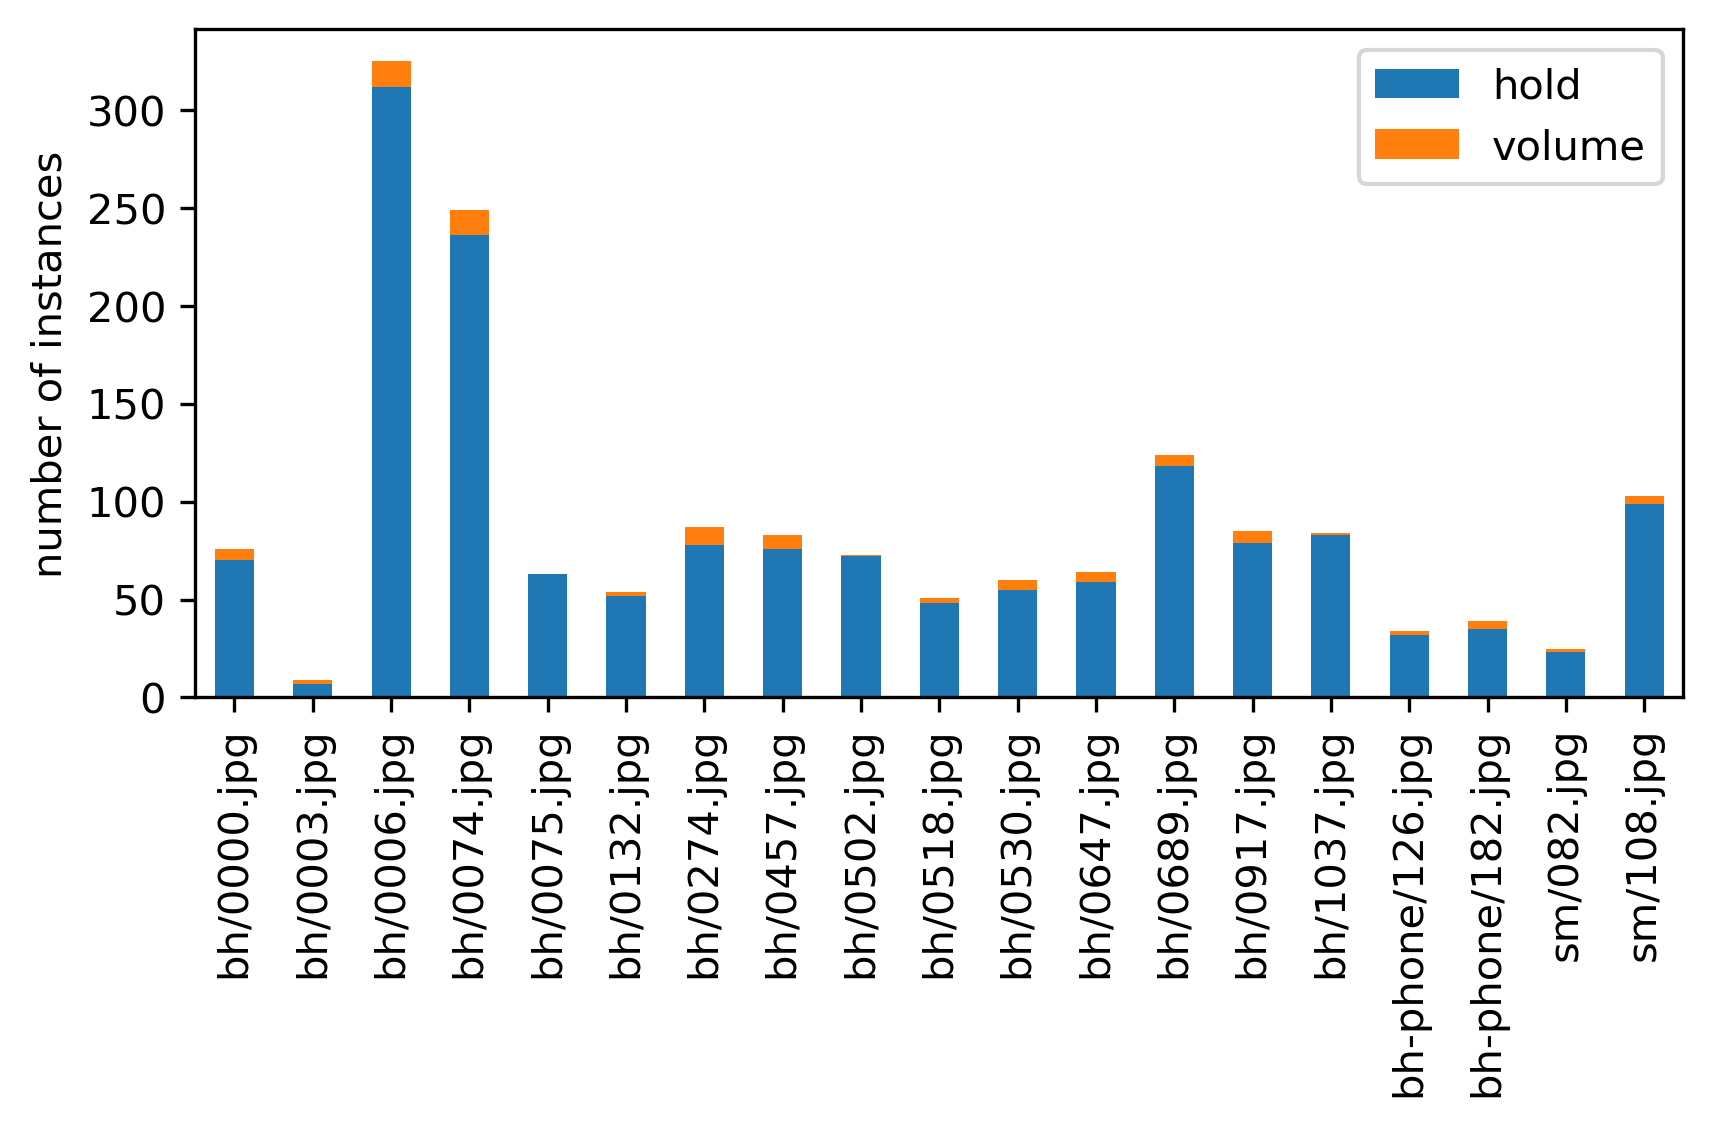

In [68]:
fig, ax = plt.subplots()
df.plot(ax=ax, kind="bar", stacked=True)
ax.set_ylabel("number of instances")
plt.gca().set_aspect(0.025)  # scuffed

plt.savefig('instances_per_category.pdf')

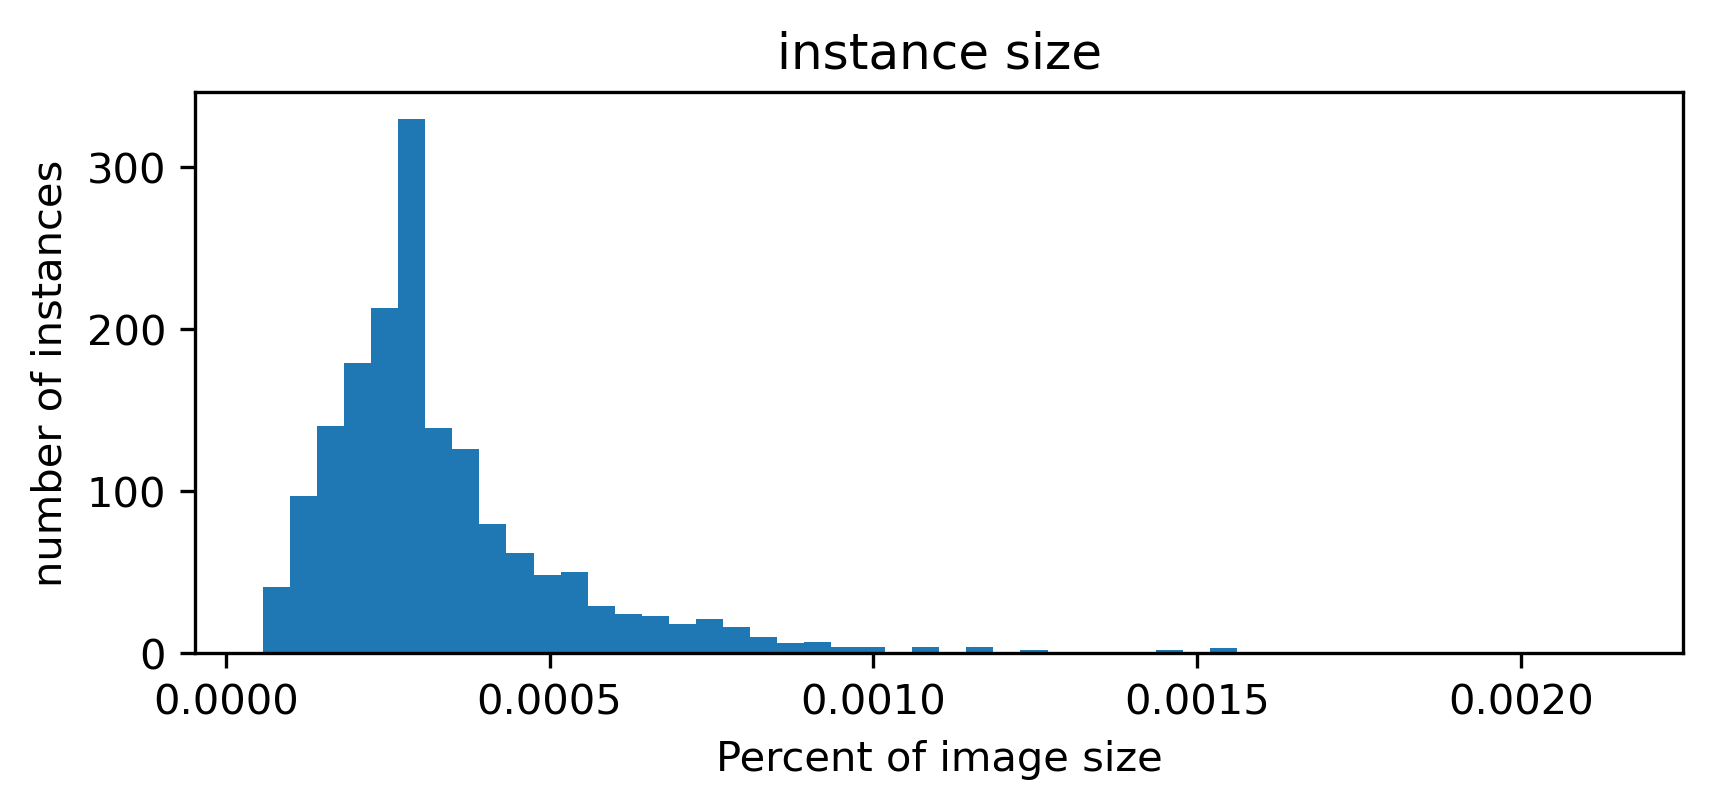

In [67]:
fig, ax = plt.subplots()
ax.hist(region_percentage, bins=50)
ax.set_xlabel("Percent of image size")
ax.set_ylabel("number of instances")
ax.set_title("instance size")
ax.set_aspect(1/400000)  # scuffed

plt.savefig('instance_size.pdf')